<a href="https://colab.research.google.com/github/kimhwijin/HandsOnMachineLearing/blob/main/ComputerVision_14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow import keras
from sklearn.datasets import load_sample_image
import matplotlib as mpl
np.random.seed(42)
tf.random.set_seed(42)

# Convolution_Tensorflow

In [2]:
#픽셀값을 0~1 로
china_image = load_sample_image("china.jpg") / 255.
flower_image = load_sample_image("flower.jpg") / 255.
images = np.array([china_image, flower_image])
batch_size, height, width, channels = images.shape
print(images.shape)

(2, 427, 640, 3)


(2, 427, 640, 2)


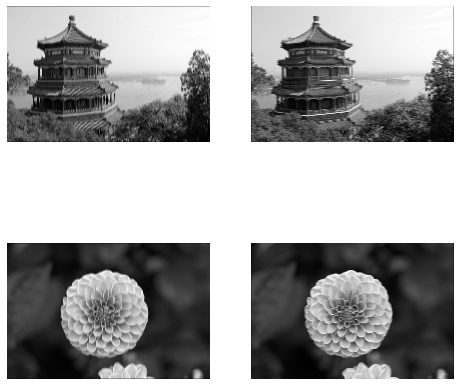

In [3]:
#2개의 수직, 수평 필터
filters = np.zeros(shape=(7,7, channels, 2), dtype=np.float32)
filters[:, 3, : ,0] = 1
filters[3, :, :, 1] = 1

#저수준 컨볼루션 뉴런 계산
outputs = tf.nn.conv2d(images, filters, strides=1, padding='SAME')
print(outputs.shape)

plt.figure(figsize=(8,8))
for image_index in (0, 1):    
    for feature_map_index in (0, 1):
        plt.subplot(2,2,image_index * 2 + feature_map_index + 1)
        plt.imshow(outputs[image_index, :, :, feature_map_index], cmap="gray", interpolation="nearest")
        plt.axis("off")
plt.show()

In [4]:
#고수준 케라스 컨볼루션 레이어
conv = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu')


# MaxPooling


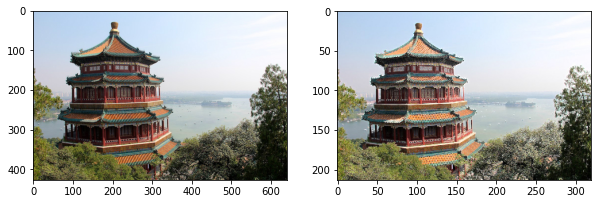

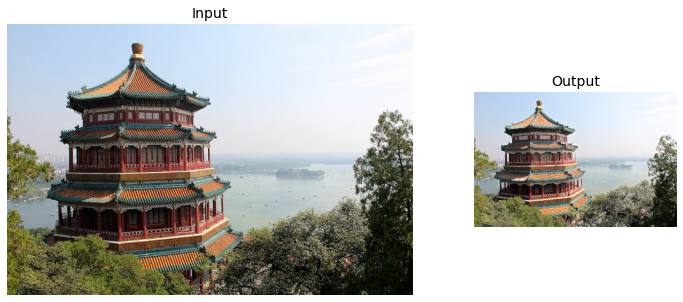

In [5]:
max_pool = keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid', input_shape=images.shape)
output = max_pool(images)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(images[0])
#plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(output[0])
#plt.axis("off")
plt.show()

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])
ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(images[0])  # 첫 번째 이미지 그리기
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output[0])  # 첫 번째 이미지 출력 그리기
ax2.axis("off")
plt.show()

# Depth_Wise_Pooling

In [6]:
class DepthMaxPool(keras.layers.Layer):
    def __init__(self, pool_size, strides=None, padding='VALID', **kwargs):
        super().__init__(**kwargs)
        if strides is None:
            strides = pool_size
        self.pool_size= pool_size
        self.strides = strides
        self.padding = padding

    def call(self, inputs):
        #batch, height, width, channel
        return tf.nn.max_pool(inputs, 
                              ksize=(1, 1, 1, self.pool_size),
                              strides=(1, 1, 1, self.strides),
                              padding=self.padding
        )


depth_pool = DepthMaxPool(3)
with tf.device("/cpu:0"): # 아직 GPU 커널이 없습니다.
    depth_output = depth_pool(images)

print(images.shape, depth_output.shape, sep='\n')

(2, 427, 640, 3)
(2, 427, 640, 1)


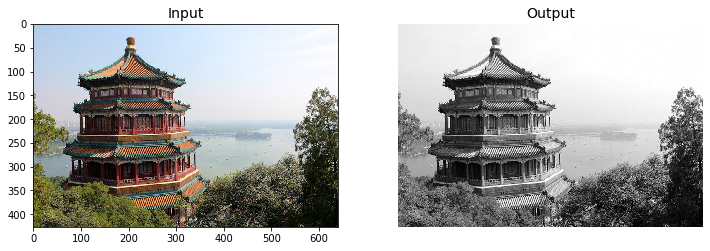

In [ ]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title("Input", fontsize=14)
plt.imshow(images[0], interpolation="nearest")  # 첫 번째 이미지 그리기
plt.subplot(1, 2, 2)
plt.title("Output", fontsize=14)
plt.imshow(depth_output[0, ... , 0], cmap='gray', interpolation='nearest')  # 첫 번째 이미지 출력 그리기
plt.axis("off")
plt.show()
#채널이 색정보를 지닌 채널이기 때문에, RGB중 가장 강한 값을 추출한다.

# Global_Avg_Pooling

In [ ]:
global_avg_pool = keras.layers.GlobalAvgPool2D()
global_output = global_avg_pool(images)
print(images.shape, global_output.shape,global_output, sep='\n')

global_avg_pool_2 = keras.layers.Lambda(lambda X: tf.reduce_mean(X, axis=[1, 2]))
global_output_2 = global_avg_pool_2(images)
print(global_output_2.shape, global_output_2, sep='\n')


(2, 427, 640, 3)
(2, 3)
tf.Tensor(
[[0.5675281  0.57046425 0.552622  ]
 [0.21621236 0.2885447  0.22353025]], shape=(2, 3), dtype=float32)
(2, 3)
tf.Tensor(
[[0.5675281  0.57046425 0.552622  ]
 [0.21621236 0.2885447  0.22353025]], shape=(2, 3), dtype=float32)


# MNIST_CNN_Model

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + keras.backend.epsilon()

X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]
print(X_train.shape)

4431872/4422102 [==============================] - 0s 0us/step
(55000, 28, 28, 1)


In [ ]:
from functools import partial

HiddenConv2D = partial(keras.layers.Conv2D, kernel_size=3, activation='relu', padding='same')

model = keras.models.Sequential([
    HiddenConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    keras.layers.MaxPool2D(pool_size=2),

    HiddenConv2D(filters=128),
    HiddenConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),

    HiddenConv2D(filters=256),
    HiddenConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),

    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax')

])

model.compile(loss=keras.losses.sparse_categorical_crossentropy, optimizer="nadam", metrics=["accuracy"])

In [ ]:
history = model.fit(X_train, y_train, epochs=10, validation_data=[X_valid, y_valid])
score = model.evaluate(X_test, y_test)
X_new = X_test[:15]
print(y_test[:15], tf.argmax(model.predict(X_new), axis=0), sep='\n')

Epoch 1/10
1719/1719 [==============================] - 40s 22ms/step - loss: 0.7063 - accuracy: 0.7552 - val_loss: 0.3579 - val_accuracy: 0.8682
Epoch 2/10
1719/1719 [==============================] - 37s 21ms/step - loss: 0.4137 - accuracy: 0.8622 - val_loss: 0.3263 - val_accuracy: 0.8788
Epoch 3/10
1719/1719 [==============================] - 37s 21ms/step - loss: 0.3579 - accuracy: 0.8801 - val_loss: 0.3065 - val_accuracy: 0.8900
Epoch 4/10
1719/1719 [==============================] - 36s 21ms/step - loss: 0.3249 - accuracy: 0.8908 - val_loss: 0.2794 - val_accuracy: 0.8974
Epoch 5/10
1719/1719 [==============================] - 37s 21ms/step - loss: 0.3050 - accuracy: 0.8966 - val_loss: 0.2889 - val_accuracy: 0.9024
Epoch 6/10
1719/1719 [==============================] - 37s 21ms/step - loss: 0.2897 - accuracy: 0.9022 - val_loss: 0.2763 - val_accuracy: 0.8992
Epoch 7/10
1719/1719 [==============================] - 37s 22ms/step - loss: 0.2728 - accuracy: 0.9066 - val_loss: 0.2730 -

# ResNet

In [ ]:
Default_3x3_1S_Conv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1, padding='same', use_bias=False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation='relu', **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)

        self.main_layers = [
            Default_3x3_1S_Conv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            Default_3x3_1S_Conv2D(filters),
            keras.layers.BatchNormalization()
        ]

        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                Default_3x3_1S_Conv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()
            ]
        
    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [ ]:
model = keras.models.Sequential()
model.add(Default_3x3_1S_Conv2D(64, kernel_size=7, strides=2, input_shape=[224, 224, 3]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same'))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(Default_3x3_1S_Conv2D(filters, strides=strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 112, 112, 64)      9408      
                                                                 
 batch_normalization (BatchN  (None, 112, 112, 64)     256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 112, 112, 64)      0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 56, 56, 64)        36864     
                                                                 
 conv2d_8 (Conv2D)           (None, 56, 56, 64)       

In [ ]:
model = keras.applications.resnet50.ResNet50(weights="imagenet")

102981632/102967424 [==============================] - 1s 0us/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


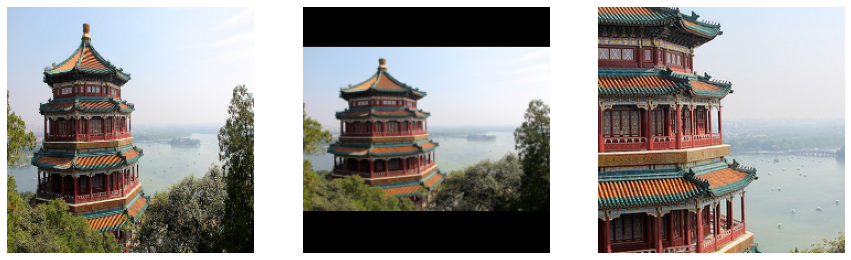

In [ ]:
plt.figure(figsize=(15, 5))

images_resized = tf.image.resize(images, [224, 224])
plt.subplot(1, 3, 1)
plt.imshow(images_resized[0])
plt.axis("off")

images_resized = tf.image.resize_with_pad(images, 224, 224, antialias=True)
plt.subplot(1, 3, 2)
plt.imshow(images_resized[0])
plt.axis("off")

images_resized = tf.image.resize_with_crop_or_pad(images, 224, 224)
plt.subplot(1, 3, 3)
plt.imshow(images_resized[0])
plt.axis("off")
plt.show()

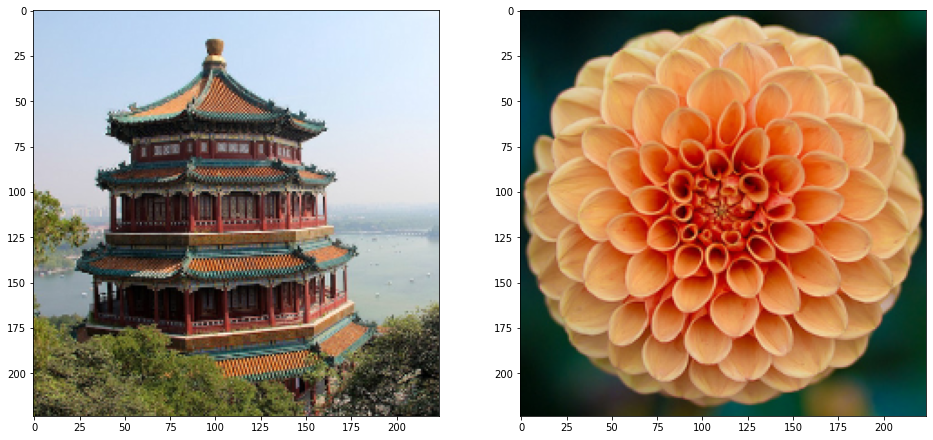

In [ ]:
#crop with box
#y0, x0, y1, x1
china_box = [0, 0.03, 1, 0.68]
flower_box = [0.19, 0.26, 0.86, 0.7]

plt.figure(figsize=(16, 8))

images_resized = tf.image.crop_and_resize(images, boxes=[china_box, flower_box], box_indices=[0, 1], crop_size=[224, 224])
plt.subplot(1, 2, 1)
plt.axis=("off")
plt.imshow(images_resized[0])

plt.subplot(1, 2, 2)
plt.axis=("off")
plt.imshow(images_resized[1])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


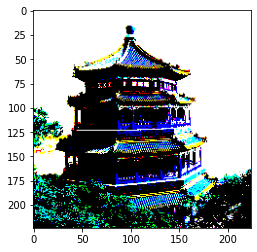

(2, 1000)
49152/35363 [=========================================] - 0s 0us/step
Image #0
  n03877845 - palace       43.39%
  n02825657 - bell_cote    43.07%
  n03781244 - monastery    11.70%

Image #1
  n04522168 - vase         53.96%
  n07930864 - cup          9.52%
  n11939491 - daisy        4.97%



In [ ]:
inputs = keras.applications.resnet50.preprocess_input(images_resized * 255)
plt.imshow(inputs[0])
plt.show()

Y_proba = model.predict(inputs)
#1000개의 레이블 확률
print(Y_proba.shape)

top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
    print("Image #{}".format(image_index))
    for class_id, name, y_proba in top_K[image_index]:
        print("  {} - {:12s} {:.2f}%".format(class_id, name, y_proba * 100))
    print()

# Xception


In [ ]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]


Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [ ]:
class_names = info.features["label"].names
n_classes = info.features["label"].num_classes
dataset_size = info.splits["train"].num_examples
print(info, class_names, n_classes, dataset_size, sep='\n')

tfds.core.DatasetInfo(
    name='tf_flowers',
    version=3.0.1,
    description='A large set of images of flowers',
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
    }),
    total_num_examples=3670,
    splits={
        'train': 3670,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
    redistribution_info=,
)

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']
5
3670


In [ ]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load( "tf_flowers", split=["train[:10%]", "train[10%:25%]", "train[25%:]"], as_supervised=True)

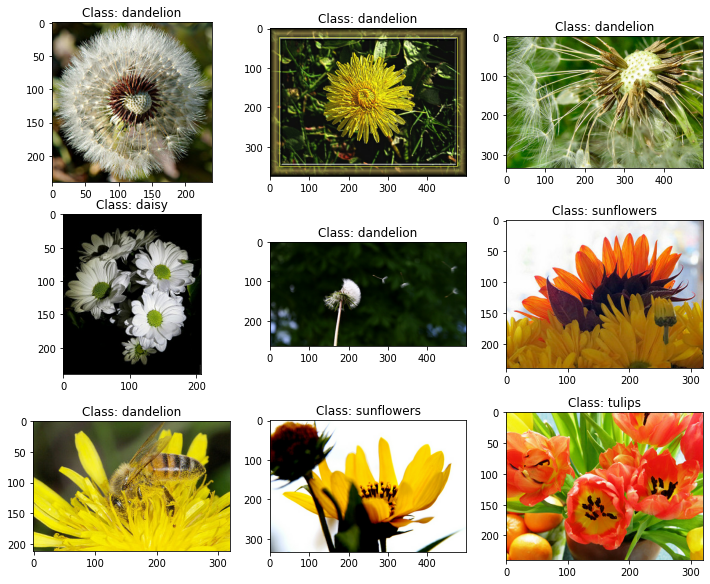

In [ ]:
plt.figure(figsize=(12, 10))
index = 0
for image, label in train_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    #plt.axis("off")

plt.show()

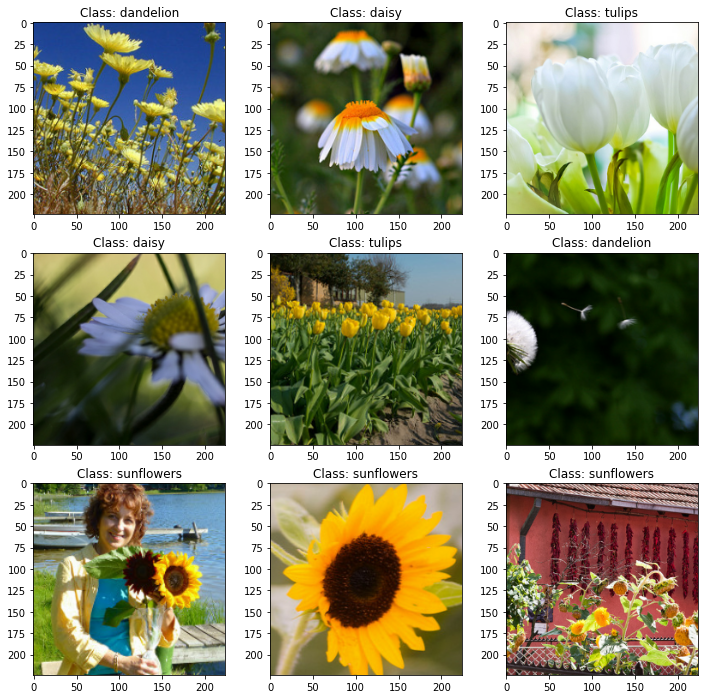

In [ ]:
#이미지 1개
def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop : bottom_crop, left_crop : right_crop]
    #return tf.image.central_crop(image, 0.9)

def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

plt.figure(figsize=(12, 12))
for X_batch, y_batch in train_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        #plt.axis("off")

plt.show()

In [ ]:
base_model = keras.applications.xception.Xception(weights='imagenet', include_top=False)
base_model.summary()

83697664/83683744 [==============================] - 1s 0us/step
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   864         ['input_2[0][0]']                
                                32)                                                               
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, None, None,   128        ['block1_conv1[0][0]']           
 ation)                   

In [ ]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)


for layer in base_model.layers:
    layer.trainable = False

#옵티마이저 
optimizer = keras.optimizers.SGD(learning_rate=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=5)


Epoch 1/5
86/86 [==============================] - 35s 373ms/step - loss: 1.3607 - accuracy: 0.7918 - val_loss: 1.3203 - val_accuracy: 0.8015
Epoch 2/5
86/86 [==============================] - 31s 361ms/step - loss: 0.5667 - accuracy: 0.8950 - val_loss: 0.9500 - val_accuracy: 0.8603
Epoch 3/5
86/86 [==============================] - 31s 360ms/step - loss: 0.3390 - accuracy: 0.9259 - val_loss: 0.7543 - val_accuracy: 0.8640
Epoch 4/5
86/86 [==============================] - 31s 360ms/step - loss: 0.2024 - accuracy: 0.9393 - val_loss: 0.7498 - val_accuracy: 0.8640
Epoch 5/5
86/86 [==============================] - 31s 359ms/step - loss: 0.1814 - accuracy: 0.9542 - val_loss: 0.7541 - val_accuracy: 0.8603


In [ ]:
for layer in base_model.layers:
    layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [ ]:
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=40)

Epoch 1/40
86/86 [==============================] - 120s 1s/step - loss: 0.3125 - accuracy: 0.8964 - val_loss: 1.3630 - val_accuracy: 0.7629
Epoch 2/40
86/86 [==============================] - 113s 1s/step - loss: 0.0978 - accuracy: 0.9680 - val_loss: 0.3787 - val_accuracy: 0.8842
Epoch 3/40
86/86 [==============================] - 113s 1s/step - loss: 0.0569 - accuracy: 0.9804 - val_loss: 0.2845 - val_accuracy: 0.8989
Epoch 4/40
86/86 [==============================] - 114s 1s/step - loss: 0.0339 - accuracy: 0.9884 - val_loss: 0.3416 - val_accuracy: 0.9007
Epoch 5/40
86/86 [==============================] - 113s 1s/step - loss: 0.0291 - accuracy: 0.9898 - val_loss: 0.2842 - val_accuracy: 0.9154
Epoch 6/40
86/86 [==============================] - 113s 1s/step - loss: 0.0260 - accuracy: 0.9909 - val_loss: 0.3494 - val_accuracy: 0.9228
Epoch 7/40
86/86 [==============================] - 113s 1s/step - loss: 0.0204 - accuracy: 0.9931 - val_loss: 0.2744 - val_accuracy: 0.9301
Epoch 8/40
86

# Inception_Implement

In [ ]:
class InceptionModule(keras.layers.Layer):
    def __init__(self, filters, **kwargs):
        super().__init__(**kwargs)
        filters_1x1 = filters[0:2] + filters[3:4] + filters[5:]
        filters_3x3 = filters[2]
        filters_5x5 = filters[4]
        self.conv1x1_1 = keras.layers.Conv2D(filters_1x1[0], kernel_size=1, strides=1, padding="same")
        self.conv1x1_2 = keras.layers.Conv2D(filters_1x1[1], kernel_size=1, strides=1, padding="same")
        self.conv1x1_3 = keras.layers.Conv2D(filters_1x1[2], kernel_size=1, strides=1, padding="same")
        self.conv1x1_4 = keras.layers.Conv2D(filters_1x1[3], kernel_size=1, strides=1, padding="same")

        self.conv3 = keras.layers.Conv2D(filters_3x3, kernel_size=3, strides=1, padding="same")
        self.conv5 = keras.layers.Conv2D(filters_5x5, kernel_size=3, strides=1, padding="same")

        self.max_pool = keras.layers.MaxPooling2D(pool_size=3, strides=1, padding="same")

    def call(self, inputs):
        Z_1 = self.conv1x1_1(inputs)

        Z_2 = self.conv1x1_2(inputs)
        Z_2 = self.conv3(Z_2)

        Z_3 = self.conv1x1_3(inputs)
        Z_3 = self.conv5(Z_3)

        Z_4 = self.max_pool(inputs)
        Z_4 = self.conv1x1_4(Z_4)

        return keras.layers.Concatenate(axis=-1)([Z_1, Z_2, Z_3, Z_4])

In [ ]:
inputs = keras.layers.Input(shape=[224,224, 3])
Z = keras.layers.Conv2D(64, kernel_size=7, strides=2, padding="same")(inputs)
Z = keras.layers.MaxPooling2D(pool_size=3, strides=2, padding="same")(Z)
Z = keras.layers.BatchNormalization()(Z)
Z = keras.layers.Conv2D(64, kernel_size=1, strides=1, padding="same")(Z)
Z = keras.layers.Conv2D(192, kernel_size=3, strides=1, padding="same")(Z)
Z = keras.layers.BatchNormalization()(Z)
Z = keras.layers.MaxPooling2D(pool_size=3, strides=2, padding="same")(Z)
Z = InceptionModule(filters=[64,96,128,16,32,32])(Z)
Z = InceptionModule(filters=[128,128,192,32,96,64])(Z)
Z = keras.layers.MaxPooling2D(pool_size=3, strides=2, padding="same")(Z)
Z = InceptionModule(filters=[192,96,208,16,48,64])(Z)
Z = InceptionModule(filters=[160,112,224,24,64,64])(Z)
Z = InceptionModule(filters=[192,96,208,16,48,64])(Z)
Z = InceptionModule(filters=[128,128,256,24,64,64])(Z)
Z = InceptionModule(filters=[112,144,288,32,64,64])(Z)
Z = InceptionModule(filters=[256,160,320,32,128,128])(Z)
Z = keras.layers.MaxPooling2D(pool_size=3, strides=2, padding="same")(Z)
Z = InceptionModule(filters=[256,160,320,32,128,128])(Z)
Z = InceptionModule(filters=[384,192,384,48,128,128])(Z)
Z = keras.layers.GlobalAvgPool2D()(Z)
Z = keras.layers.Dropout(0.4)(Z)
outputs = keras.layers.Dense(1000, activation='softmax')(Z)

In [ ]:
model = keras.models.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_31 (Conv2D)          (None, 112, 112, 64)      9472      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization_9 (Batc  (None, 56, 56, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_32 (Conv2D)          (None, 56, 56, 64)        4160      
                                                                 
 conv2d_33 (Conv2D)          (None, 56, 56, 192)       1107

In [ ]:
model.compile(loss=keras.losses.sparse_categorical_crossentropy, optimizer="nadam", metrics=["accuracy"])

# Xception_Implement

In [ ]:
class XceptionModule(keras.layers.Layer):
    def __init__(self, filter):
        self.depthwise = keras.layers.Conv2D(filter, kernel_size=3, strides=1, padding='same')
        self.pointwise = keras.layers.Conv2D(filter, kernel_size=1, strides=1, padding="same")
    
    def call(self, inputs):
        Z = inputs
        Z = self.depthwise(Z)
        Z = keras.layers.BatchNormalization()(Z)
        Z = self.pointwise(Z)
        return keras.layers.BatchNormalization()(Z)

# Resnet_Implement


In [ ]:
class ResNetUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation='relu', **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            keras.layers.Conv2D(filters, 3, strides=strides, padding="samen", use_bias=False),
            keras.layers.BatchNormalization(),
            self.activation,
            keras.layers.Conv2D(filters, 3, strides=1, padding="same", use_bias=False),
            keras.layers.BatchNormalization()
        ]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                keras.layers.Conv2D(filters, kernel_size=1, strides=strides, padding="same", use_bias=False),
                keras.layers.BatchNormalization()
            ]


    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        
        return self.activation(skip_Z + Z)

# SE_Block_Implement

In [ ]:
class SE_Block(keras.layers.Layer):
    def __init__(self, filters, ratio=16):
        self.global_avg_pool = keras.layers.GlobalAveragePooling2D()
        self.squeeze = keras.layers.Dense(filters//ratio, activation='relu')
        self.excitation = keras.layers.Dense(filters, activation='sigmoid')
    
    def call(self, inputs):
        Z = self.global_avg_pool(inputs)
        Z = self.squeeze(Z)
        return self.excitation(Z)

# Location_Estimation

In [ ]:
base_model = keras.applications.xception.Xception(weights='imagenet', include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = keras.layers.Dense(n_classes, activation='softmax')(avg)
loc_output = keras.layers.Dense(4)(avg)
model = keras.Model(inputs=base_model.input, outputs=[class_output, loc_output])
model.compile(loss=["sparse_categorical_crossentropy", "mse"], loss_weights=[0.8, 0.2], optimizer=optimizer, metrics=['accuracy'])


In [ ]:
def add_fake_bounding_boxes(images, labels):
    fake_bound_boxes = tf.random.uniform([tf.shape(images)[0], 4])
    return images, (labels, fake_bound_boxes)

fake_train_set = train_set.take(5).repeat(2).map(add_fake_bounding_boxes)
model.fit(fake_train_set, steps_per_epoch=5, epochs=2)

Epoch 1/2
5/5 [==============================] - 13s 1s/step - loss: 1.3011 - dense_6_loss: 1.5530 - dense_7_loss: 0.2932 - dense_6_accuracy: 0.2500 - dense_7_accuracy: 0.2313
Epoch 2/2
5/5 [==============================] - 6s 1s/step - loss: 1.1005 - dense_6_loss: 1.3291 - dense_7_loss: 0.1860 - dense_6_accuracy: 0.4688 - dense_7_accuracy: 0.2625


# mAP Metric

In [5]:
#y_true = [percentage_class1 ... 5] + [bounding_box1 ... 4] * 5 + [bounding_box_existence_score] * 5
#사용자 정의 스트리밍 지표
class mAPMetric(keras.metrics.Metric):
    def __init__(self, iou_threshold=0.5, **kwargs):
        super().__init__(**kwargs)
        self.iou_threshold = iou_threshold

        #변수 생성 메서드
    
    def update_state(self, y_true, y_pred):
        
        #1차적으로 객체 클래스 맞는지 확인.
        #2차적으로 iou 값구하기
        #iou 값이 threshold를 넘기면 true로 판별
        #정밀도 (true positive / true positive + false positive 값) 구하기
        pass

    def result(self):
        pass
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "iou_threshold": self.iou_threshold}
    